In [1]:
import sys
sys.path.insert(1, '..')
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sqlalchemy import create_engine

from snorkel.labeling import labeling_function

## Load Data

### DataFrame

In [2]:
## load the data by choosing a random 10% of the data
## is the data ordered? am I missing a large chunk due to my partial loading?
# p = 0.01
# responses = pd.read_csv('../data/moralmachine/SharedResponses.csv', skiprows=lambda i: i>0 and random.random() > p)

### SQL Engine

In [3]:
# access SQL DB with data
engine = create_engine("sqlite:///../data/moralmachine.db", echo=False)

In [4]:
# demo
# responses = pd.read_sql("SELECT * FROM sharedresponses ORDER BY RANDOM() LIMIT 100000", con=engine)
# responses.columns

In [5]:
# ## For viewing the possible values for each feature
# for feature in responses.columns:
#     print(feature)
#     print(responses[feature].unique())
#     print(responses[feature].unique().shape)

In [6]:
# ## What does a single user's session/response look like?
# responses_random = responses[responses['ScenarioTypeStrict'] == 'Random']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     ## see a random user's session
# #     display(responses_random[responses_random['ExtendedSessionID'] == responses_random['ExtendedSessionID'].sample().values[0]])
    
#     ## see the user with nth most responses
#     n = 100
#     display(responses_random[responses_random['ResponseID'] == responses_random.groupby(by='ResponseID').size().sort_values(ascending=False).index[n]]) 

In [7]:
# ## group alternatives pairwise!
# # take only responses where both alternatives are present in the random sample - for a full sample, this step isn't necessary
# responses_grouped = responses.groupby(by='ResponseID').filter(lambda g: g.shape[0] < 2)
# responses_grouped.shape

## Data Exploration

In [8]:
# responses.describe()

## Snorkel Labeling
Using https://www.snorkel.org/use-cases/01-spam-tutorial

### Sample Data

In [9]:
# query random sample of responses grouped by ResponseID; only take responses for which both instances are present
sample_size = 10000
query = """
    SELECT gc.session_count, sr.* FROM sharedresponses sr
    INNER JOIN (
        SELECT ExtendedSessionID, COUNT(DISTINCT ResponseID) AS session_count FROM sharedresponses
        WHERE UserID <> ''
        
        /* Get only full sessions. */
        GROUP BY ExtendedSessionID
            HAVING COUNT(DISTINCT ResponseID) LIKE 13
                AND COUNT(ResponseID) LIKE 26
        
        LIMIT {0:d}
    ) gc
        ON gc.ExtendedSessionID = sr.ExtendedSessionID
    ORDER BY sr.UserID
""".format(sample_size)
df = pd.read_sql(query, con=engine)
df

,session_count,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
0,13,6CZMPysjNTnnbf9mH,-1602033933_1000321014360919.0,1000321014360920,2,0,0,1,0,Pets,...,0,0,0,0,0,0,0,0,2,3
1,13,DMsAJitFrYPAr5QMn,-1602033933_1000321014360919.0,1000321014360920,7,0,1,0,0,Less,...,0,0,0,0,0,0,0,0,0,0
2,13,EbLdFTxg8y8LegW56,-1602033933_1000321014360919.0,1000321014360920,11,0,1,0,1,High,...,0,0,0,0,0,0,0,0,0,0
3,13,6CZMPysjNTnnbf9mH,-1602033933_1000321014360919.0,1000321014360920,2,1,0,0,0,Hoomans,...,0,0,1,0,0,0,1,1,0,0
4,13,DMsAJitFrYPAr5QMn,-1602033933_1000321014360919.0,1000321014360920,7,1,1,0,0,More,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259995,13,zwDvL5ekbn9rs6YZM,-1191309859_9998163172675142.0,9998163172675140,4,0,0,1,0,Male,...,0,0,0,0,0,0,0,0,0,0
259996,13,vqsLNjvCdnHSvows4,-1191309859_9998163172675142.0,9998163172675140,8,1,0,1,0,Old,...,0,0,0,0,0,0,0,0,0,0
259997,13,y2u8uWS9XhemMNuAP,-1191309859_9998163172675142.0,9998163172675140,9,1,0,1,0,Low,...,0,0,0,0,0,0,0,0,0,0
259998,13,zcfyxtj396WNrbtEE,-1191309859_9998163172675142.0,9998163172675140,5,1,1,0,1,Less,...,0,0,0,0,0,0,1,0,0,0


For comparison to Noothigattu et al., how many pairwise comparisons per voter in this sample dataset?

In [10]:
# number of pairwise comparisons per voter?
# = number of response IDs per voter
df.groupby('UserID')['ResponseID'].nunique().mean()

14.002585092632486

In [11]:
df.iloc[:26,:].sort_values('ScenarioOrder')

,session_count,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
12,13,hi3YDtrPdjhjedZZj,-1602033933_1000321014360919.0,1000321014360920,1,0,1,0,0,Fat,...,0,0,0,0,0,0,0,0,0,0
18,13,hi3YDtrPdjhjedZZj,-1602033933_1000321014360919.0,1000321014360920,1,1,1,0,0,Fit,...,0,0,0,0,0,0,0,0,0,0
3,13,6CZMPysjNTnnbf9mH,-1602033933_1000321014360919.0,1000321014360920,2,1,0,0,0,Hoomans,...,0,0,1,0,0,0,1,1,0,0
0,13,6CZMPysjNTnnbf9mH,-1602033933_1000321014360919.0,1000321014360920,2,0,0,1,0,Pets,...,0,0,0,0,0,0,0,0,2,3
19,13,i5DgQrFZDJyXR2fNe,-1602033933_1000321014360919.0,1000321014360920,3,1,0,1,0,Less,...,0,0,1,0,0,0,0,0,0,0
13,13,i5DgQrFZDJyXR2fNe,-1602033933_1000321014360919.0,1000321014360920,3,0,0,0,2,More,...,0,0,1,1,0,0,0,0,1,0
25,13,zn9NZHBDC9rx2F2Nx,-1602033933_1000321014360919.0,1000321014360920,4,1,1,0,2,High,...,0,0,2,0,0,0,0,0,0,0
22,13,zn9NZHBDC9rx2F2Nx,-1602033933_1000321014360919.0,1000321014360920,4,0,1,0,1,Low,...,0,0,0,0,0,0,0,0,0,0
14,13,aJQfwAvizuFM5TBH4,-1602033933_1000321014360919.0,1000321014360920,5,1,0,0,1,Rand,...,0,0,0,0,0,0,0,0,1,0
8,13,aJQfwAvizuFM5TBH4,-1602033933_1000321014360919.0,1000321014360920,5,0,0,1,0,Rand,...,2,1,0,1,0,0,0,0,0,0


Out of the variables above, these are the variables that vary within response pairs:
> 'NumberOfCharacters', 'DiffNumberOfCharacters', 'Saved', 'Template', 'DescriptionShown',
'LeftHand', 'UserCountry3', 'Man', 'Woman', 'Pregnant', 'Stroller',
'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman',
'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive',
'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog',
'Cat'

N.B. in each pair of responses, only one is the result of an intervention, and only one is saved. 

In [13]:
df[["ResponseID","Intervention","Saved"]].head()

,ResponseID,Intervention,Saved
0,6CZMPysjNTnnbf9mH,0,0
1,DMsAJitFrYPAr5QMn,0,0
2,EbLdFTxg8y8LegW56,0,1
3,6CZMPysjNTnnbf9mH,1,1
4,DMsAJitFrYPAr5QMn,1,1


### Preprocessing

First, let's convert to abstract features for ease of labeling.

In [184]:
import hmm.labeling.utils
importlib.reload(hmm.labeling.utils)
from hmm.labeling.utils import transform_abstract

ids = ['ResponseID', 'ExtendedSessionID', 'UserID']
df_i = df.set_index(ids, append=True, verify_integrity=True)
df_i.index = df_i.index.set_names(['UUID']+ids)
df_abstract = transform_abstract(df_i)
df_abstract.head()

,,,,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
UUID,ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
0,6CZMPysjNTnnbf9mH,-1602033933_1000321014360919.0,1000321014360920,13,2,0,1,0,Pets,Species,Species,Hoomans,Pets,...,0,0,0,0,0,0,5,1,1,1
1,DMsAJitFrYPAr5QMn,-1602033933_1000321014360919.0,1000321014360920,13,7,1,0,0,Less,Utilitarian,Utilitarian,More,Less,...,0,0,0,0,0,3,0,0,0,1
2,EbLdFTxg8y8LegW56,-1602033933_1000321014360919.0,1000321014360920,13,11,1,0,1,High,Social Status,Social Status,High,Low,...,0,0,0,0,0,1,0,0,1,0
3,6CZMPysjNTnnbf9mH,-1602033933_1000321014360919.0,1000321014360920,13,2,0,0,0,Hoomans,Species,Species,Hoomans,Pets,...,0,1,2,0,0,5,0,0,0,1
4,DMsAJitFrYPAr5QMn,-1602033933_1000321014360919.0,1000321014360920,13,7,1,0,0,More,Utilitarian,Utilitarian,More,Less,...,0,0,0,0,0,4,1,0,0,1


Now let's check our work.

In [185]:
sample = df_i.sample().index
df_i.loc[sample]

,,,,session_count,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,...,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Passenger,Law Abiding,Law Violating
UUID,ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
69762,QRk8q53hdTRqpPJEp,-1563182584_2579754840.0,2579754840,13,10,0,1,0,1,More,Utilitarian,Utilitarian,More,...,0,0,0,0,1,1,0,False,True,False


In [186]:
df_abstract.loc[sample]

,,,,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
UUID,ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
69762,QRk8q53hdTRqpPJEp,-1563182584_2579754840.0,2579754840,13,10,1,0,1,More,Utilitarian,Utilitarian,More,Less,...,0,0,1,0,0,4,1,0,1,0


In [187]:
df_abstract.columns

Index(['session_count', 'ScenarioOrder', 'PedPed', 'Barrier', 'CrossingSignal',
       'AttributeLevel', 'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'NumberOfCharacters',
       'DiffNumberOFCharacters', 'Saved', 'Template', 'DescriptionShown',
       'LeftHand', 'UserCountry3', 'Intervene', 'Male', 'Female', 'Young',
       'Old', 'Infancy', 'Pregnancy', 'Fat', 'Fit', 'Working', 'Medical',
       'Homeless', 'Criminal', 'Human', 'Non-human', 'Passenger',
       'Law Abiding', 'Law Violating'],
      dtype='object')

First, select the fields that are unique to each scenario (the fields that vary within pairs of responses). Then split the dataset into two disjoint sets of alternatives: one in which an intervention occurs, and one in which there is no intervention.

In [188]:
ids = ["ResponseID", "ExtendedSessionID", "UserID"]
scenario_fields = [
    'Saved', 'NumberOfCharacters', 'DescriptionShown', 'LeftHand', 'Male', 'Female', 'Young', 'Old', 'Infancy', 'Pregnancy',
    'Fat', 'Fit', 'Working', 'Medical', 'Homeless', 'Criminal', 'Human',
    'Non-human', 'Passenger', 'Law Abiding', 'Law Violating'
]

df_abstract = df_abstract.reset_index(level='UUID')
sample_response = df_abstract.sample().index
intervention = df_abstract[df_abstract['Intervene'] == 1][scenario_fields]
no_intervention = df_abstract[df_abstract['Intervene'] == 0][scenario_fields]

print("Alternative w/ intervention:")
display(intervention.loc[sample_response])
print("Alternative w/o intervention:")
display(no_intervention.loc[sample_response])

Alternative w/ intervention:


,,,Saved,NumberOfCharacters,DescriptionShown,LeftHand,Male,Female,Young,Old,Infancy,Pregnancy,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
px72Xfh42Dvey45Ti,-1515635037_7014932942427610.0,7014932942427610,1,2,0,0,2,0,1,0,0,0,...,0,0,0,0,0,2,0,0,0,0


Alternative w/o intervention:


,,,Saved,NumberOfCharacters,DescriptionShown,LeftHand,Male,Female,Young,Old,Infancy,Pregnancy,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
px72Xfh42Dvey45Ti,-1515635037_7014932942427610.0,7014932942427610,0,5,0,1,2,2,1,0,0,0,...,0,1,1,1,0,5,0,1,1,1


Next, combine the datasets on response ID, separating the variable characteristics with suffixes.

In [189]:
df_endo = intervention.join(no_intervention, lsuffix='_int', rsuffix='_noint', how='inner')
df_endo.loc[sample_response]

,,,Saved_int,NumberOfCharacters_int,DescriptionShown_int,LeftHand_int,Male_int,Female_int,Young_int,Old_int,Infancy_int,Pregnancy_int,...,Fit_noint,Working_noint,Medical_noint,Homeless_noint,Criminal_noint,Human_noint,Non-human_noint,Passenger_noint,Law Abiding_noint,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
px72Xfh42Dvey45Ti,-1515635037_7014932942427610.0,7014932942427610,1,2,0,0,2,0,1,0,0,0,...,0,1,1,1,0,5,0,1,1,1


Get data for the columns from the raw data that _didn't_ change within response pairs. Remember to eliminate duplicate response pairs - now that we have a combined tuple for each pairwise comparison, they're no longer necessary.

In [190]:
df_exo = df_abstract[[col for col in df_abstract.columns if col not in scenario_fields]]
df_exo = df_exo.loc[~df_exo.index.duplicated(keep='first')]
df_exo.loc[sample_response]

,,,UUID,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,DefaultChoiceIsOmission,DiffNumberOFCharacters,Template,UserCountry3,Intervene
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,
px72Xfh42Dvey45Ti,-1515635037_7014932942427610.0,7014932942427610,199595,13,12,0,1,0,More,Utilitarian,Utilitarian,More,Less,1,3,Mobile,JPN,0


Then join that data in with the combined endogenous variables to get a full tuple for each pairwise comparison presented to a user.

In [191]:
df_joined = df_exo.join(df_endo, how='inner').set_index(['UUID'], append=True, verify_integrity=True)
sample = df_joined.sample().index
df_joined.loc[sample]

,,,,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,Fit_noint,Working_noint,Medical_noint,Homeless_noint,Criminal_noint,Human_noint,Non-human_noint,Passenger_noint,Law Abiding_noint,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
jWS4hFnHEjdMRthtR,-1114206846_326927762,326927762,101830,13,6,0,0,1,More,Utilitarian,Utilitarian,More,Less,...,0,1,0,0,1,4,1,0,1,0


In [192]:
import hmm.labeling.utils
importlib.reload(hmm.labeling.utils)
from hmm.labeling.utils import pictofy
    
# works with abstract
pictofy(df_joined.loc[sample])

What should the self-driving car do? (ScenarioType: Utilitarian)

	    🚘 
	   |	\ 
	   v 	 v
	🟢🚸 	🚧🔴
	 NOINT	INT	
INT saves: 
['1 Male', '1 Old', '1 Criminal', '2 Human']
NOINT saves: 
['1 Male', '2 Female', '1 Young', '1 Old', '1 Working', '1 Criminal', '4 Human', '1 Non-human']



How much data did we lose with all these joins? Shouldn't be any - all we're doing is dividing the dataset in half.

In [193]:
print("df: {}".format(df.shape))
print("df_endo: {}".format(df_endo.shape))
print("df_exo: {}".format(df_exo.shape))
print("df_joined: {}".format(df_joined.shape))

df: (260000, 42)
df_endo: (130000, 42)
df_exo: (130000, 16)
df_joined: (130000, 57)


Finally, let's make it easier to interpret the target variable. For each response, we know whether the user chose to save one set of characters (\_int) by intervention, or save another set (\_noint) by not intervening. Let's call that variable "Intervened" to indicate whether or not the user intervened (swerved the AV).

In [194]:
df_joined['Intervened'] = (df_joined['Saved_int'] == 1).astype(int)
df_joined = df_joined.drop(axis='columns', labels=['Saved_{}'.format(s) for s in ['int', 'noint']]+["Intervene"])
scenario_fields.remove('Saved')
df_joined.columns

Index(['session_count', 'ScenarioOrder', 'PedPed', 'Barrier', 'CrossingSignal',
       'AttributeLevel', 'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'DiffNumberOFCharacters',
       'Template', 'UserCountry3', 'NumberOfCharacters_int',
       'DescriptionShown_int', 'LeftHand_int', 'Male_int', 'Female_int',
       'Young_int', 'Old_int', 'Infancy_int', 'Pregnancy_int', 'Fat_int',
       'Fit_int', 'Working_int', 'Medical_int', 'Homeless_int', 'Criminal_int',
       'Human_int', 'Non-human_int', 'Passenger_int', 'Law Abiding_int',
       'Law Violating_int', 'NumberOfCharacters_noint',
       'DescriptionShown_noint', 'LeftHand_noint', 'Male_noint',
       'Female_noint', 'Young_noint', 'Old_noint', 'Infancy_noint',
       'Pregnancy_noint', 'Fat_noint', 'Fit_noint', 'Working_noint',
       'Medical_noint', 'Homeless_noint', 'Criminal_noint', 'Human_noint',
       'Non-human_noint', 'Passenger_noint', 'Law Abiding_noint',


Now choose which features to use:

In [195]:
# include user countries and other metadata or not? decided not - experts writing LFs are trying to decide most moral response, not predict what an individual from a certain background would do
# but if it helps generalization, technically useful... try both?
features = [
    "Intervened", "Template", "UserCountry3"
] + ["{}_{}".format(f, s) for f in scenario_fields for s in ["int"]]
cat_features = [
    "Template", "UserCountry3"
]
num_features = [f for f in features if f not in cat_features]
df_joined[features].head()

,,,,Intervened,Template,UserCountry3,NumberOfCharacters_int,DescriptionShown_int,LeftHand_int,Male_int,Female_int,Young_int,Old_int,...,Fit_int,Working_int,Medical_int,Homeless_int,Criminal_int,Human_int,Non-human_int,Passenger_int,Law Abiding_int,Law Violating_int
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
6CZMPysjNTnnbf9mH,-1602033933_1000321014360919.0,1000321014360920,0,1,Desktop,CAN,5,1,1,3,1,2,0,...,0,1,2,0,0,5,0,0,0,1
DMsAJitFrYPAr5QMn,-1602033933_1000321014360919.0,1000321014360920,1,1,Desktop,CAN,5,1,1,0,3,2,0,...,0,0,0,0,0,4,1,0,0,1
EbLdFTxg8y8LegW56,-1602033933_1000321014360919.0,1000321014360920,2,0,Desktop,CAN,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
RLwefgv4ABrZ8bhbr,-1602033933_1000321014360919.0,1000321014360920,6,0,Desktop,CAN,1,1,1,0,1,0,0,...,0,0,0,0,0,1,0,1,1,1
aJQfwAvizuFM5TBH4,-1602033933_1000321014360919.0,1000321014360920,8,0,Desktop,CAN,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Now explicitly type cast and deal with NA's or missing values:

In [199]:
# transform numerical data types
df_proc = df_joined.loc[:,features]

def transform_num(df, num_features):
    # convert to numeric, changing literals to NaN
    for f in num_features:
        df.loc[:, f] = pd.to_numeric(df.loc[:, f], errors='coerce')
    # are there any nan in the numerical features? usually just one
    nan = df[df[num_features].isna().any(axis=1)]
    print("Dropping these NaN:")
    display(nan)
    return df.dropna(axis=0, how='any', subset=num_features)

df_proc = transform_num(df_proc, num_features)

Dropping these NaN:


,,,,Intervened,Template,UserCountry3,NumberOfCharacters_int,DescriptionShown_int,LeftHand_int,Male_int,Female_int,Young_int,Old_int,...,Fit_int,Working_int,Medical_int,Homeless_int,Criminal_int,Human_int,Non-human_int,Passenger_int,Law Abiding_int,Law Violating_int
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
9XqeeDRQxdjXGtysP,-1132097515_1001529134,1001529134,52,0,,ROU,1,NaN,NaN,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
KQCdXCp4BcnqmmEky,-1132097515_1001529134,1001529134,54,1,,ROU,2,NaN,NaN,1,1,0,0,...,0,0,0,0,0,2,0,1,1,1
Ljhao6hyR8PAtMEP4,-1132097515_1001529134,1001529134,55,1,,ROU,2,NaN,NaN,0,2,0,1,...,0,0,0,0,0,2,0,1,1,1
MB9o7ub7KkvdWaD6j,-1132097515_1001529134,1001529134,56,1,,ROU,3,NaN,NaN,3,0,0,0,...,2,1,0,0,0,3,0,1,1,1
PRPQctv4Jzbxo7pMM,-1132097515_1001529134,1001529134,57,1,,ROU,1,NaN,NaN,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oSMYndMTGRgNpR6YW,-1534003712_994600747,994600747,258923,1,,USA,2,NaN,NaN,1,0,0,0,...,0,0,0,1,0,2,0,1,1,1
qkgyMbp8Re2bzp9gk,-1534003712_994600747,994600747,258924,0,,USA,2,NaN,NaN,0,2,0,0,...,0,1,0,0,0,2,0,0,0,1
rix9H3uPSgZgv5DG3,-1534003712_994600747,994600747,258925,1,,USA,3,NaN,NaN,0,3,0,2,...,0,0,0,0,0,3,0,0,1,0


### Train/Test Split

A standard train test split for testing:

In [200]:
import hmm.classification
importlib.reload(hmm.classification)
from hmm.classification import train_test_val_dev_split

def make_X_y(df):
    X = df.drop(labels=["Intervened"], axis='columns', inplace=False)
    y = df["Intervened"]
    return X, y

X, y = make_X_y(df_proc)
X_train, X_test, X_val, X_dev, y_train, y_test, y_val, y_dev = train_test_val_dev_split(X, y)
display(X_train.head())
display(y_train.head())

,,,,Template,UserCountry3,NumberOfCharacters_int,DescriptionShown_int,LeftHand_int,Male_int,Female_int,Young_int,Old_int,Infancy_int,...,Fit_int,Working_int,Medical_int,Homeless_int,Criminal_int,Human_int,Non-human_int,Passenger_int,Law Abiding_int,Law Violating_int
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
8WGWehjqbYuXsuH87,-1626934076_2926387036253344.0,2926387036253340,85542,Desktop,TUR,2,0.0,1.0,0,2,1,1,0,...,0,0,0,0,0,2,0,1,1,1
dvPyN9HuDB3AMWtsT,-1191581109_3417446436445093.0,3417446436445090,109265,Mobile,UKR,4,0.0,0.0,4,0,1,2,0,...,0,1,0,0,0,4,0,1,1,1
kvdfPiBAwBL32pJNj,-1415444696_6299672654761641.0,6299672654761640,185602,Mobile,ITA,2,0.0,1.0,0,2,0,0,0,...,1,0,1,0,0,2,0,0,1,0
69Bcss7ri6HLtFZzk,-1477211334_8986213842923065.0,8986213842923070,239697,Desktop,BEL,5,1.0,0.0,1,1,2,0,2,...,0,1,1,1,0,5,0,0,0,1
sZYqiFWWX7rQHufGD,-1084551384_3157728151.0,3157728151,96636,Mobile,ITA,2,0.0,1.0,0,2,1,0,0,...,0,1,0,0,0,2,0,1,1,1


ResponseID         ExtendedSessionID               UserID            UUID  
8WGWehjqbYuXsuH87  -1626934076_2926387036253344.0  2926387036253340  85542     0
dvPyN9HuDB3AMWtsT  -1191581109_3417446436445093.0  3417446436445090  109265    1
kvdfPiBAwBL32pJNj  -1415444696_6299672654761641.0  6299672654761640  185602    1
69Bcss7ri6HLtFZzk  -1477211334_8986213842923065.0  8986213842923070  239697    1
sZYqiFWWX7rQHufGD  -1084551384_3157728151.0        3157728151        96636     0
Name: Intervened, dtype: int64

### Labeling Model

Some sample labeling functions, constructed with the help of the effect sizes in the Moral Machine experiment.

In [201]:
import hmm.labeling.moralmachine as mm
import hmm.labeling.models
importlib.reload(hmm.labeling.moralmachine)
importlib.reload(hmm.labeling.models)

from hmm.labeling.models import Labeler
from snorkel.labeling import LFAnalysis

lfs = [
    mm.doctors,
    mm.utilitarian,
    mm.utilitarian_anthro,
    mm.inaction,
    mm.pedestrians,
    mm.females,
    mm.fitness,
    mm.status,
    mm.legal,
    mm.illegal,
    mm.youth,
    mm.criminals,
    mm.homeless,
    mm.pets,
    mm.spare_strollers,
    mm.spare_girl,
    mm.spare_boy,
    mm.spare_pregnant
]

labeler = Labeler(lfs)
L_train, L_dev, L_val = labeler.label([X_train, X_dev, X_val])
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=y_dev.values).sort_values("Correct", ascending=False)

/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/71493 [00:00<?, ?it/s]

KeyError: ('MaleDoctor_noint', 'occurred at index (8WGWehjqbYuXsuH87, -1626934076_2926387036253344.0, 2926387036253340, 85542)')

## Aggregation

Recall that there are no true labels for this problem - really, we're just measuring similarity of the heuristic labels to real voter's responses. 

**Baseline**: majority label voting.

In [164]:
from snorkel.labeling import MajorityLabelVoter

model_majority = MajorityLabelVoter()
preds_train = model_majority.predict(L=L_train)

**Label Model**: Snorkel aggregator. Chooses weights to combine the labeling functions based on learned conditional probabilities.

In [165]:
# cardinality is num classes
importlib.reload(hmm.labeling.models)

model_label = labeler.fit(L_train)
pd.DataFrame([[lf.name for lf in lfs], model_label.get_weights()])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,doctors,utilitarian,utilitarian_anthro,inaction,pedestrians,females,fitness,status,legal,illegal,youth,criminals,homeless,pets,spare_strollers,spare_girl,spare_boy,spare_pregnant
1,1,1,1,0.5,0.501748,0.892141,0.637497,0.979292,0.49923,0.515469,1,0.913941,0.500479,1,1,1,0.801037,1


How much does the label model improve on the majority voter?

In [166]:
importlib.reload(hmm.labeling.models)
from hmm.labeling.models import Labeler

for model in [model_majority, model_label]:
    Labeler.score(model, L_val, y_val)

MajorityLabelVoter() Vote Accuracy:            64.9
LabelModel() Vote Accuracy:            66.8


### Eye Test - Debugging Label Model

A handy function for viewing pairwise alternatives:

Now, use the label model to create probabilistic labels for the dev set. Rounding off, create binary predictions.

In [167]:
from snorkel.analysis import get_label_buckets

threshold = 0.5
probs_dev = model_label.predict_proba(L=L_dev)
preds_dev = probs_dev >= threshold

Create label buckets for eyeball debugging (groups TP, FP, TN, FN).

In [168]:
# confusion matrix
print(labeler.get_confusion_matrix(L_dev, y_dev))
buckets = labeler.get_label_buckets(L_dev, y_dev)

Predicted  False  True 
Actual                 
False       1653    437
True         973   1406


What is the accuracy for each scenario type?

In [169]:
# false negatives
df_fn_dev = X_dev.iloc[buckets[(1, 0)]]
# false positives
df_fp_dev = X_dev.iloc[buckets[(0, 1)]]
df_n_dev = X_dev.iloc[np.concatenate([buckets[(1, 0)], buckets[(0, 1)]])]
# acc = 1 - Neg / Total for each scenario type
acc = 1 - df_joined.loc[df_n_dev.index, 'ScenarioType'].value_counts() / df_joined.loc[X_dev.index, 'ScenarioType'].value_counts()
acc.sort_values()

Gender           0.547226
Fitness          0.606504
Social Status    0.614100
Random           0.634234
Age              0.716440
Utilitarian      0.783476
Species          0.842033
Name: ScenarioType, dtype: float64

#### False Negatives
Here, the user chose to intervene, while the label model did not. 

In [170]:
# get the corresponding posteriori probability for each false negative
df_fn_dev.loc[:,"probability"] = probs_dev[buckets[(1, 0)], 1]
# check out a few
pictofy(df_fn_dev.sample())

What should the self-driving car do? (ScenarioType: Unknown)

	    🚘 
	   |	\ 
	   v 	 v
	 🚸 	🚧 
	 NOINT	INT	
INT saves: 
['Man', 'Woman', 'Woman', 'LargeWoman', 'LargeMan']
NOINT saves: 
['FemaleAthlete', 'FemaleAthlete', 'FemaleAthlete', 'MaleAthlete', 'MaleAthlete']



/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

Which scenario types does the model tend to get wrong?

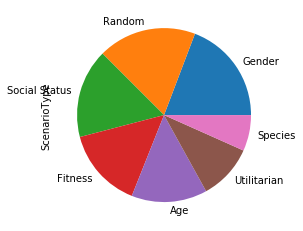

In [171]:
df_joined.loc[df_fn_dev.index, 'ScenarioType'].value_counts().plot.pie()

#### False Positives
Here, the user chose not to intervene, but the label model did.

In [172]:
# get the corresponding posteriori probability for each false positive
df_fp_dev.loc[:,"probability"] = probs_dev[buckets[(0, 1)], 1]
# check out a few
pictofy(df_fp_dev.sample(random_state=3))

What should the self-driving car do? (ScenarioType: Unknown)

	    🚘 
	   |	\ 
	   v 	 v
	 🚧 	🚸🔴
	 NOINT	INT	
INT saves: 
['Man', 'Woman', 'Boy', 'Girl']
NOINT saves: 
['Woman', 'OldMan', 'OldMan', 'OldWoman']



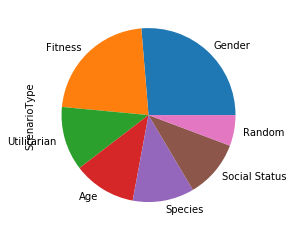

In [173]:
df_joined.loc[df_fp_dev.index, 'ScenarioType'].value_counts().plot.pie()

## Classification

https://www.snorkel.org/use-cases/01-spam-tutorial#5-training-a-classifier

### Featurization

Let's design a simple machine learning classifier for this problem, then test it on both the gold standard labels and the heuristic labels.

In [174]:
import hmm.classification
importlib.reload(hmm.classification)
from hmm.classification import Classifier

clf = Classifier(features, num_features, cat_features)

#### Training on Gold Labels

Using just the labels (no label model):

In [175]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

Test Accuracy: 70.5%


0.7048061321546467

#### Training on Heuristic Labels

Using the label model, filter out unlabeled points:

In [176]:
X_train_filtered, probs_train_filtered = labeler.filter_probs(X_train, L_train)
# check if filtered X_train has same columns
# X_train_filtered.columns == X_train.columns
# how many were filtered?
X_train.shape[0] - X_train_filtered.shape[0]

0

In [177]:
preds_train_filtered = Labeler.probs_to_preds(probs_train_filtered)
clf.fit(X_train_filtered, preds_train_filtered)
clf.score(X_test, y_test)

Test Accuracy: 66.0%


0.6597101773625021

### Grid Search Testing

**Which labeling functions add the most predictive performance?**

In [41]:
acc_full = Labeler.score(model_label, L_val, y_val)
for lf in lfs:
    lfs_perturb = [l for l in lfs if l != lf]
    l = Labeler(lfs_perturb)
    L_train, L_dev, L_val = l.label([X_train, X_dev, X_val], verbose=False)
    lm = labeler.fit(L_train)
    acc_perturb = Labeler.score(lm, L_val, y_val, verbose=False)
    print("{}: {}".format(lf.name, acc_full - acc_perturb))

LabelModel() Vote Accuracy:            67.8
doctors: 0.0
utilitarian: 0.002488638822765621
utilitarian_anthro: 0.0022181346028997684
inaction: -0.014715429560701154


KeyboardInterrupt: 

**Which models perform best?**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

for name, model in {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Log Reg": LogisticRegression(C=.001),
    "KNN": KNeighborsClassifier(3),
    "SVC Linear": SVC(kernel="linear", C=0.025),
    "SVC Nonlinear": SVC(gamma=2, C=1),
    "GP": GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "RF": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "MLP": MLPClassifier(alpha=1, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}.items():
    print("## {} ##".format(name))
    clf = Classifier(features, num_features, cat_features, clf=model)
    
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test, verbose=False)
    print("Accuracy with gold labels: {}".format(acc))
    
    clf.fit(X_train_filtered, preds_train_filtered)
    acc = clf.score(X_test, y_test, verbose=False)
    print("Accuracy with heuristic labels: {}".format(acc))

## Random Forest ##
Accuracy with gold labels: 0.6969270720623242
Accuracy with heuristic labels: 0.6713373728630166
## Log Reg ##


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with gold labels: 0.7052045011902186


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with heuristic labels: 0.6623566327634711
## KNN ##


**How does performance change as the number of voters is increased?** 

In this case, evaluate performance voter-wise by splitting the data after stratifying by voter.

In [154]:
data = []
users = df_proc.groupby(['UserID'])
a = np.arange(users.ngroups)
np.random.shuffle(a)
for i in range(2,8):
    n = 2**i
    print("## Testing N={}##".format(n))
    n_respondents = df_proc[users.ngroup().isin(a[:n])]
    # checking to make sure we're getting complete, single sessions
    # some users may have more than one session...
#     n_respondents.groupby('UserID').count().describe()
    X, y = make_X_y(n_respondents)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=X.index.get_level_values('ExtendedSessionID')
    )
#     y_train.groupby('ExtendedSessionID').count()
    L_train, L_test = labeler.label([X_train, X_test])
    lm = labeler.fit(L_train)
    Labeler.score(lm, L_test, y_test, verbose=False)
    X_train_filtered, probs_train_filtered = labeler.filter_probs(X_train, L_train)
    # baseline gold model accuracy
    print("Gold accuracy")
    clf.fit(X_train, y_train)
    acc_gold = clf.score(X_test, y_test)
    # label model accuracy
    print("LF accuracy")
    preds_train_filtered = Labeler.probs_to_preds(probs_train_filtered)
    clf.fit(X_train_filtered, preds_train_filtered)
    acc_lf = clf.score(X_test, y_test)
    data.append((n, acc_gold, acc_lf))
data

/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 26/26 [00:00<00:00, 861.93it/s]

## Testing N=4##


Gold accuracy
Test Accuracy: 61.5%
LF accuracy


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 47/47 [00:00<00:00, 903.56it/s]

Test Accuracy: 53.8%
## Testing N=8##


Gold accuracy
Test Accuracy: 66.0%
LF accuracy


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
 64%|██████▎   | 84/132 [00:00<00:00, 837.85it/s]

Test Accuracy: 55.3%
## Testing N=16##


100%|██████████| 89/89 [00:00<00:00, 949.95it/s]


Gold accuracy
Test Accuracy: 62.9%
LF accuracy


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
 71%|███████   | 183/257 [00:00<00:00, 917.75it/s]

Test Accuracy: 67.4%
## Testing N=32##


100%|██████████| 172/172 [00:00<00:00, 905.01it/s]


Gold accuracy
Test Accuracy: 65.7%
LF accuracy


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
 36%|███▌      | 186/522 [00:00<00:00, 915.94it/s]

Test Accuracy: 65.1%
## Testing N=64##


100%|██████████| 349/349 [00:00<00:00, 920.99it/s]


Gold accuracy


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/1021 [00:00<?, ?it/s]

Test Accuracy: 57.9%
LF accuracy
Test Accuracy: 62.8%
## Testing N=128##


100%|██████████| 682/682 [00:00<00:00, 848.21it/s]


Gold accuracy
Test Accuracy: 62.8%
LF accuracy
Test Accuracy: 63.3%


[(4, 0.6153846153846154, 0.5384615384615384),
 (8, 0.6595744680851063, 0.5531914893617021),
 (16, 0.6292134831460674, 0.6741573033707865),
 (32, 0.6569767441860465, 0.6511627906976745),
 (64, 0.5787965616045845, 0.6275071633237822),
 (128, 0.6275659824046921, 0.6334310850439883)]

## Kim et al. Implementation

A replication of the model used by [Kim et al.](https://www.mendeley.com/viewer/?fileId=1b0d79d6-97a3-f7e5-3008-2e14db1a767b&documentId=3f4000f0-5830-358b-a8ea-b031e3ab5403) for estimating voter preferences. Will compare accuracy to Snorkel method.

Here, modeling _utilities_ as $u(\Theta_i) = w^\intercal F(\Theta_i)$, where $\Theta_y$ is the character vector for instance $y$ and $F : \Theta \to \Lambda$ is the mapping from the character vector to an abstract vector. This is accomplished by $F(\Theta) = A\Theta$, where $A$ is a binary matrix denoting the presence of abstract characterisitics.

### Benchmark 1

$u(\Theta) = w^{c\intercal}\Theta$, where $w^c \sim N_k(\mu, \sigma^2I)$.

In [67]:
## TODO: how to estimate w^c?